# Double Plays vs outs/FCs

```python
# Manual threshold
dfc["threshold_rounded"] = (-0.05
                           + 0.40 * dfc["pitcher_shakespearianism_with_vibe"]
                           - 0.18 * dfc["batter_inv_tragicness"]
                           + 0.10 * dfc['fielder_tenaciousness_with_vibe']
                           - 0.18 * (dfc["ballpark_elongation"] - 0.5)
                           )
dfc.loc[dfc["threshold_rounded"] < 0.001, "threshold_rounded"] = 0.001
# {
#     return "It's okay Joel"
# }
```

In [1]:
import glob

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.markers import CARETLEFTBASE, CARETRIGHTBASE

all_files = glob.glob("roll_data/*Z-dp.csv")

df = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)

seasons = [11,12,13,14]
# seasons = [11]
df = df[df['season'].isin(seasons)]

# 'rolls' is a list of 3 rolls (None if no 3rd roll). Split into three columns
df['roll'] = df['roll'].apply(lambda x: x[1:-1].split(','))
splitrolls = pd.DataFrame(df['roll'].to_list(), columns = ['roll1','roll2','roll3'], index = df.index)
df[['roll1','roll2','roll3']] = splitrolls
df[['roll1','roll2']] = df[['roll1','roll2']].apply(pd.to_numeric)

len(df)
# splitrolls

4114

In [2]:
def get_pitcher_mul(row):
    pm = str(row["pitcher_mods"])
    ptm = str(row["pitching_team_mods"])
    mul = 1
    if "OVERPERFORMING" in pm:
        mul += 0.2
    if "OVERPERFORMING" in ptm:
        mul += 0.2
    if "UNDERPERFORMING" in pm:
        mul -= 0.2
    if "UNDERPERFORMING" in ptm:
        mul -= 0.2
    if "TRAVELING" in ptm:
        if not row["top_of_inning"]:
            mul += 0.05
    if "HIGH_PRESSURE" in ptm:
        if row["weather"] == "Weather.FLOODING" and row["baserunner_count"] > 0:
            mul += 0.25
    if "GROWTH" in ptm:
        mul += min(0.05, 0.05 * (row["day"] / 99))
    if "SINKING_SHIP" in ptm:
        mul += (14 - row["pitching_team_roster_size"]) * 0.01
    if "AFFINITY_FOR_CROWS" in ptm and row["weather"] == "Weather.BIRDS":
        mul += 0.5
    return mul


def get_batter_mul(row):
    bm = str(row["batter_mods"])
    btm = str(row["batting_team_mods"])
    ptm = str(row["pitching_team_mods"])
    mul = 1
    if "OVERPERFORMING" in bm:
        mul += 0.2
    if "OVERPERFORMING" in btm:
        mul += 0.2
    if "UNDERPERFORMING" in bm:
        mul -= 0.2
    if "UNDERPERFORMING" in btm:
        mul -= 0.2
    if "TRAVELING" in btm:
        # pass
        if row["top_of_inning"]:
        # this doesn't seem to do anything if it's here or not here
            mul += 0.05
    if "GROWTH" in btm:
        mul += min(0.05, 0.05 * (row["day"] / 99))
        # pass
    if "HIGH_PRESSURE" in btm:
        if row["weather"] == "Weather.FLOODING" and row["baserunner_count"] > 0:
            mul += 0.25
    if "SINKING_SHIP" in btm:
        mul += (14 - row["batting_team_roster_size"]) * 0.01
    if "AFFINITY_FOR_CROWS" in btm and row["weather"] == "Weather.BIRDS":
        mul += 0.5
    if "CHUNKY" in bm and row["weather"] == "Weather.PEANUTS":
        # todo: handle, in peanuts weather
        pass
        # mul += 1.0
    if "SMOOTH" in bm and row["weather"] == "Weather.PEANUTS":
        # todo: handle, in peanuts weather
        pass
    if "ON_FIRE" in bm:
        # todo: handle
        mul += 2.0
    #         pass
    return mul


def get_fielder_mul(row):
    fm = str(row["fielder_mods"])
    ptm = str(row["pitching_team_mods"])
    mul = 1
    if "OVERPERFORMING" in fm:
        mul += 0.2
    if "OVERPERFORMING" in ptm:
        mul += 0.2
    if "UNDERPERFORMING" in fm:
        mul -= 0.2
    if "UNDERPERFORMING" in ptm:
        mul -= 0.2
    if "TRAVELING" in ptm:
        # pass # traveling just doesn't do anything on pitchers?
        if not row["top_of_inning"]:
            mul += 0.05
    if "HIGH_PRESSURE" in ptm:
        # i messed up baserunner_count lol, so it's a string
        if row["weather"] == "Weather.FLOODING" and row["baserunner_count"] > 0:
            mul += 0.25
    if "GROWTH" in ptm:
        mul += min(0.05, 0.05 * (row["day"] / 99))
        # pass # growth doesn't do anything on pitchers either
    if "SINKING_SHIP" in ptm:
        mul += (14 - row["pitching_team_roster_size"]) * 0.01
    if "AFFINITY_FOR_CROWS" in ptm and row["weather"] == "Weather.BIRDS":
        mul += 0.5
    if "SHELLED" in fm:
        # is it this, or is it "mul = 0", I wonder
        mul -= 1.0
    return mul

In [3]:
df["batter_mul"] = df.apply(get_batter_mul, axis=1)
df["pitcher_mul"] = df.apply(get_pitcher_mul, axis=1)
df["fielder_mul"] = df.apply(get_fielder_mul, axis=1)

In [4]:
df.loc[df["pitcher_mods"].astype(str).str.contains("SCATTERED"), "pitcher_vibes"] = 0
df.loc[df["batter_mods"].astype(str).str.contains("SCATTERED"), "batter_vibes"] = 0
df.loc[df["fielder_mods"].astype(str).str.contains("SCATTERED"), "fielder_vibes"] = 0
df.loc[df["runner_on_first_mods"].astype(str).str.contains("SCATTERED"), "runner_on_first_vibes"] = 0


df['batter_inv_patheticism'] = 1-df['batter_patheticism']/df["batter_multiplier"]
df['batter_inv_patheticism_with_vibe'] = df['batter_inv_patheticism'] * (1 + 0.2*df['batter_vibes'])
df['batter_inv_tragicness'] = 1-df['batter_tragicness']/df["batter_multiplier"]
df['batter_inv_tragicness_with_vibe'] = df['batter_inv_tragicness'] * (1 + 0.2*df['batter_vibes'])
for attr in [
    # "batter_buoyancy",
    # "batter_divinity",
    "batter_martyrdom",
    # "batter_moxie",
    # "batter_musclitude",
    # "batter_patheticism",
    # "batter_thwackability",
    # "batter_tragicness",
    # "batter_coldness",
    # "batter_overpowerment",
    # "batter_ruthlessness",
    # "batter_shakespearianism",
    # "batter_suppression",
    # "batter_unthwackability",
    # "batter_base_thirst",
    # "batter_continuation",
    # "batter_ground_friction",
    # "batter_indulgence",
    # "batter_laserlikeness",
    # "batter_anticapitalism",
    # "batter_chasiness",
    # "batter_omniscience",
    # "batter_tenaciousness",
    # "batter_watchfulness",
    # "batter_pressurization",
    # "batter_cinnamon",
]:
    df[attr] = df[attr] * df["batter_mul"]
    df[attr + "_with_vibe"] = df[attr] * (1 + 0.2 * df["batter_vibes"])

# for attr in [
#     "runner_on_first_buoyancy",
#     "runner_on_first_divinity",
#     "runner_on_first_martyrdom",
#     "runner_on_first_moxie",
#     "runner_on_first_musclitude",
#     "runner_on_first_patheticism",
#     "runner_on_first_thwackability",
#     "runner_on_first_tragicness",
#     "runner_on_first_coldness",
#     "runner_on_first_overpowerment",
#     "runner_on_first_ruthlessness",
#     "runner_on_first_shakespearianism",
#     "runner_on_first_suppression",
#     "runner_on_first_unthwackability",
#     "runner_on_first_base_thirst",
#     "runner_on_first_continuation",
#     "runner_on_first_ground_friction",
#     "runner_on_first_indulgence",
#     "runner_on_first_laserlikeness",
#     "runner_on_first_anticapitalism",
#     "runner_on_first_chasiness",
#     "runner_on_first_omniscience",
#     "runner_on_first_tenaciousness",
#     "runner_on_first_watchfulness",
#     "runner_on_first_pressurization",
#     "runner_on_first_cinnamon",
# ]:
#     df[attr] = df[attr] * df["runner_on_first_multiplier"]
#     df[attr + "_with_vibe"] = df[attr] * (1 + 0.2 * df["runner_on_first_vibes"])
for attr in [
    # "pitcher_buoyancy",
    # "pitcher_divinity",
    # "pitcher_martyrdom",
    # "pitcher_moxie",
    # "pitcher_musclitude",
    # "pitcher_patheticism",
    # "pitcher_thwackability",
    # "pitcher_tragicness",
    # "pitcher_ruthlessness",
    # "pitcher_overpowerment",
    # "pitcher_unthwackability",
    "pitcher_shakespearianism",
    # "pitcher_suppression",
    # "pitcher_coldness",
    # "pitcher_base_thirst",
    # "pitcher_continuation",
    # "pitcher_ground_friction",
    # "pitcher_indulgence",
    # "pitcher_laserlikeness",
    # "pitcher_anticapitalism",
    # "pitcher_chasiness",
    # "pitcher_omniscience",
    # "pitcher_tenaciousness",
    # "pitcher_watchfulness",
    # "pitcher_pressurization",
    # "pitcher_cinnamon",
]:
    df[attr] = df[attr] * df["pitcher_mul"]
    df[attr + "_with_vibe"] = df[attr] * (1 + 0.2 * df["pitcher_vibes"])

for attr in [
    # "fielder_anticapitalism",
    # "fielder_chasiness",
    # "fielder_omniscience",
    "fielder_tenaciousness",
    # "fielder_watchfulness",
]:
    # patch for SHELLED
    # df.loc[df["fielder_mods"].astype(str).str.contains("SHELLED"), "fielder_multiplier"] *= 0.0
    df[attr] = df[attr] * df["fielder_mul"]
    # df[attr + "_times_vibe"] = df[attr] * df["fielder_vibes"]
    df[attr + "_with_vibe"] = df[attr] * (1 + 0.2 * df["fielder_vibes"])

In [5]:
dfc = df.copy()
# for exclude_mod in ["OVERPERFORMING", "UNDERPERFORMING", "HIGH_PRESSURE", "GROWTH", "SINKING_SHIP", "TRAVELING"]:
# for exclude_mod in ["FLINCH", "O_NO", "ON_FIRE", "GROWTH", "TRAVELING"]:
#     dfc = dfc[~dfc["batter_mods"].astype(str).str.contains(exclude_mod)]
#     dfc = dfc[~dfc["pitcher_mods"].astype(str).str.contains(exclude_mod)]
#     dfc = dfc[~dfc["fielder_mods"].astype(str).str.contains(exclude_mod)]
#     dfc = dfc[~dfc["runner_on_first_mods"].astype(str).str.contains(exclude_mod)]
#     dfc = dfc[~dfc["pitching_team_mods"].astype(str).str.contains(exclude_mod)]
#     dfc = dfc[~dfc["batting_team_mods"].astype(str).str.contains(exclude_mod)]

# dfc = dfc[
#     (dfc["pitcher_multiplier"] == 1)
#     & (dfc["batter_multiplier"] == 1)
#     & (dfc["fielder_multiplier"] == 1)
#     & (dfc["runner_on_first_multiplier"] == 1)
# ]
# dfc = dfc[(dfc['pitcher_vibes'].abs() < 0.2) & (dfc['batter_vibes'].abs() < 0.2)]
# for limit_attr in ['batter_patheticism', 'batter_thwackability', 'batter_divinity', 'batter_musclitude', 'pitcher_ruthlessness']:
#     dfc = dfc[(dfc[limit_attr] > 0.1) & (dfc[limit_attr] < 0.9)]
# dfc = dfc[dfc['batter_thwackability'] + dfc['batter_musclitude'] + dfc['batter_divinity'] > dfc['batter_patheticism']]

len(dfc)

4114

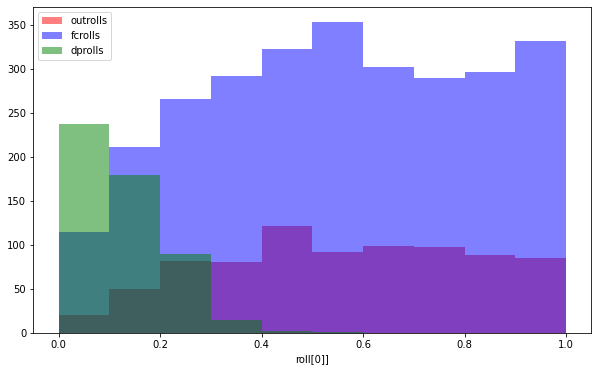

In [6]:
# This shows the first roll is related to DP vs other
# The fc_dp notebook shows the second roll is related to FC vs Out
fig, ax = plt.subplots(1, figsize=(10, 6), facecolor='white')
# ax.hist(
#     df[df['event_type'].isin(['FC','Out'])]['roll1'],
#     bins=10,
#     range=[0.,1.],
#     color="blue",
#     label="fcorout_rolls",
#     alpha = 0.5
# )
ax.hist(
    dfc[dfc['event_type']=='Out']['roll1'],
    bins=10,
    range=[0.,1.], 
    color="red",
    label="outrolls",
    alpha = 0.5
)
ax.hist(
    dfc[dfc['event_type']=='FC']['roll1'],
    bins=10,
    range=[0.,1.],
    color="blue",
    label="fcrolls",
    alpha = 0.5
)
ax.hist(
    dfc[dfc['event_type']=='DP']['roll1'],
    bins=10,
    range=[0.,1.],
    color="green",
    label="dprolls",
    alpha = 0.5
)

ax.set_xlabel('bin counts')
ax.set_xlabel("roll[0]")

ax.legend()

In [7]:
X = dfc[
    [
        "roll1",
        "passed",
        # "batter_patheticism_with_vibe",
        # "batter_tragicness_with_vibe",
        "batter_inv_tragicness",
        "pitcher_shakespearianism_with_vibe",
        # 'fielder_anticapitalism_with_vibe',
        # 'fielder_chasiness_with_vibe',
        # 'fielder_omniscience_with_vibe',
        'fielder_tenaciousness_with_vibe',
        # 'fielder_watchfulness_with_vibe',
        # 'ballpark_grandiosity',
        # 'ballpark_fortification',
        # 'ballpark_obtuseness',
        # 'ballpark_ominousness',
        # 'ballpark_inconvenience',
        # 'ballpark_viscosity',
        # 'ballpark_forwardness',
        # 'ballpark_mysticism',
        'ballpark_elongation',
        # 'runner_on_first_tragicness_with_vibe',
        # 'runner_on_first_laserlikeness_with_vibe',
        # 'runner_on_first_continuation_with_vibe',
        # 'runner_on_first_ground_friction_with_vibe',
        # 'runner_on_first_indulgence_with_vibe',
        # 'ballpark_filthiness',
    ]
]

X = X[X["roll1"] > 0.001]

# X = dfc[['roll', 'pitcher_ruthlessness', 'ballpark_forwardness']]
# X = dfc[['roll', 'pitcher_ruthlessness']]

# Test out a specific coefficient
# X["roll1"] = X["roll1"]-0.4*X["pitcher_shakespearianism_with_vibe"]
# X.drop("pitcher_shakespearianism_with_vibe", axis="columns", inplace=True)
# X["roll1"] = X["roll1"]-0.1*X["fielder_tenaciousness_with_vibe"]
# X.drop("fielder_tenaciousness_with_vibe", axis="columns", inplace=True)
y = X["passed"]
X = X.drop("passed", axis=1)
X

,roll1,batter_inv_tragicness,pitcher_shakespearianism_with_vibe,fielder_tenaciousness_with_vibe,ballpark_elongation
0,0.252581,0.940000,0.620725,0.295401,0.404077
1,0.423702,0.940000,0.620725,0.550431,0.404077
2,0.966077,0.900000,0.984897,0.605374,0.436543
3,0.831990,0.940000,1.055878,0.483374,0.562553
4,0.209812,0.900000,0.984897,0.482277,0.436543
...,...,...,...,...,...
4109,0.249282,0.940000,0.747509,0.349308,0.503937
4110,0.565652,0.957387,0.747068,0.441007,0.555106
4111,0.724748,0.940000,1.092042,0.702113,0.503937
4112,0.266896,0.900000,0.276078,0.379895,0.570287


In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import svm, linear_model

# # trainedsvm = svm.SVC(kernel='linear').fit(X, y)
# trainedsvm = svm.LinearSVC(dual=False, max_iter=100000).fit(X, y)
# predictionsvm = trainedsvm.predict(X)
# print(confusion_matrix(y,predictionsvm))
# print(classification_report(y,predictionsvm))

sc = StandardScaler()
X2 = sc.fit_transform(X)

#trainedsvm = svm.LinearSVC(intercept_scaling=1000, dual=False, max_iter=100000, C=1000, class_weight="balanced").fit(
trainedsvm = svm.LinearSVC(dual=False, max_iter=100000, C=1000).fit(
    X2, y
)
predictionsvm = trainedsvm.predict(X2)
print(confusion_matrix(y, predictionsvm))
print(classification_report(y, predictionsvm))
print(trainedsvm.score(X2, y))

[[3592    0]
 [   0  520]]
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      3592
        True       1.00      1.00      1.00       520

    accuracy                           1.00      4112
   macro avg       1.00      1.00      1.00      4112
weighted avg       1.00      1.00      1.00      4112

1.0


In [9]:
coef = np.true_divide(trainedsvm.coef_, sc.scale_)
coef_scaled = coef / coef[0, 0]
coef_list = coef_scaled.tolist()[0]

intercept = trainedsvm.intercept_ - np.dot(coef, sc.mean_)
intercept_scaled = intercept / coef[0, 0]
print(intercept_scaled)
sorted(zip(coef_list, X.columns), key=lambda x: abs(x[0]), reverse=True)

[-0.03679498]


[(1.0, 'roll1'),
 (-0.4014051288757132, 'pitcher_shakespearianism_with_vibe'),
 (0.1816381668401558, 'batter_inv_tragicness'),
 (0.17378249997160913, 'ballpark_elongation'),
 (-0.10086764526758599, 'fielder_tenaciousness_with_vibe')]

[0.03679498]
(-0.1816381668401558, 'batter_inv_tragicness')
(0.4014051288757132, 'pitcher_shakespearianism_with_vibe')
(0.10086764526758599, 'fielder_tenaciousness_with_vibe')
(-0.17378249997160913, 'ballpark_elongation')


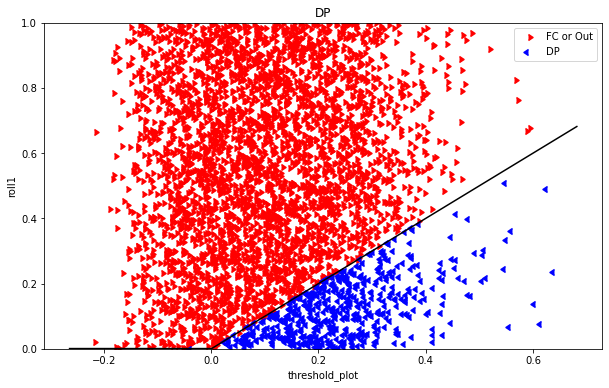

In [10]:
# Manual threshold
dfc["threshold_rounded"] = -0.05 + 0.40 * dfc["pitcher_shakespearianism_with_vibe"] - 0.18 * dfc["batter_inv_tragicness"] + 0.10 * dfc['fielder_tenaciousness_with_vibe'] - 0.18 * (dfc["ballpark_elongation"] - 0.5)
dfc.loc[dfc["threshold_rounded"] < 0.001, "threshold_rounded"] = 0.001
# {
#     return "It's okay Joel"
# }

dfc["threshold_plot"] = -0.05 + 0.40 * dfc["pitcher_shakespearianism_with_vibe"] - 0.18 * dfc["batter_inv_tragicness"] + 0.10 * dfc['fielder_tenaciousness_with_vibe'] - 0.18 * (dfc["ballpark_elongation"] - 0.5)
# SVC threshold
dfc["threshold"] = -intercept_scaled[0]
print(-intercept_scaled)
for pair in zip(-np.array(coef_list), X.columns):
    if pair[1] != "roll1":
        print(pair)
        dfc["threshold"] += pair[0] * dfc[pair[1]]

x_val = "threshold_plot"
fig, ax = plt.subplots(1, figsize=(10, 6), facecolor='white')
ax.scatter(
    dfc[~dfc["passed"]][x_val],
    dfc[~dfc["passed"]]["roll1"],
    color="red",
    label="FC or Out",
    marker=CARETRIGHTBASE,
)
ax.scatter(
    dfc[dfc["passed"]][x_val],
    dfc[dfc["passed"]]["roll1"],
    color="blue",
    label="DP",
    marker=CARETLEFTBASE,
)
ax.set_xlabel(x_val)
ax.set_ylabel("roll1")
ax.set_title("DP")
# ax.set_xlim(0.484, 0.499)
# ax.set_yscale("log")
ax.set_ylim(0, 1)

# intercept_plot = 0.40
# intercept_plot = -intercept_scaled
xline = np.linspace(*ax.get_xlim(), 2001)
# xline = np.insert(xline, 1, 0.65)
yline = xline.copy()
yline[(yline < 0.001)] = 0.001

ax.plot(xline, yline, "k")
# ax.plot(np.logspace(-4, 0), np.logspace(-4, 0), "k")
ax.legend()
fig.savefig('./Figures/dp.png')

0


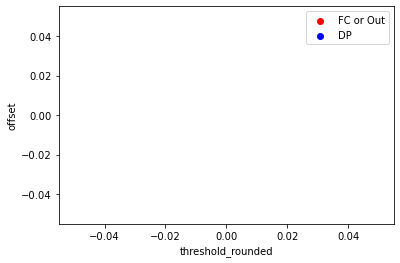

In [11]:
dfc["offset"] = dfc["roll1"] - dfc["threshold_rounded"]
outliers = dfc[(dfc["passed"] & (dfc["offset"] >= 0)) | (~dfc["passed"] & (dfc["offset"] <= 0))]
print(len(outliers))

fig, ax = plt.subplots(1, facecolor='white')
x_val = "threshold_rounded"
ax.scatter(
    outliers[~outliers["passed"]][x_val],
    outliers[~outliers["passed"]]["offset"],
    color="red",
    label="FC or Out",
)
ax.scatter(
    outliers[outliers["passed"]][x_val],
    outliers[outliers["passed"]]["offset"],
    color="blue",
    label="DP",
)
ax.set_xlabel(x_val)
ax.set_ylabel("offset")
ax.legend()

In [12]:
table = outliers
print(len(table))
#table = table[table['event_type'] == 'Out']
table[
    [
        "season",
        # "day",
        "event_type",
        "offset",
        "roll1",
        "threshold_rounded",
        "passed",
        # "batter_inv_tragicness",
        # "pitcher_shakespearianism_with_vibe",
        # 'fielder_tenaciousness_with_vibe',
        # 'ballpark_elongation',
        #"baserunner_count",
        #"top_of_inning",
        # "inning",
        # "home_score",
        # "away_score",
        #"event_type",
        #"ballpark_filthiness",
        "pitcher_name",
        "fielder_name",
        "batter_name",
        "batter_mul",
        "pitcher_mul",
        "fielder_mul",
        # "runner_on_first_name",
        "weather",
        "batter_mods",
        "pitcher_mods",
        "fielder_mods",
        # "runner_on_first_mods",
        "batting_team_mods",
        "pitching_team_mods",
        "game_id",
        "play_count",
        # 'ball_count',
        # 'strike_count',
        # 'out_count',
    ]
].sort_values("offset", ascending=True)
# len(table)

0


,season,event_type,offset,roll1,threshold_rounded,passed,pitcher_name,fielder_name,batter_name,batter_mul,pitcher_mul,fielder_mul,weather,batter_mods,pitcher_mods,fielder_mods,batting_team_mods,pitching_team_mods,game_id,play_count


In [13]:
# list(df.columns)
print(df.loc[df["passed"], "roll1"].min())
print(df.loc[~df["passed"], "roll1"].min())
print(df.loc[df["passed"], "roll1"].max())
print(df.loc[~df["passed"], "roll1"].max())

0.0005110497847138
0.0017943113906413
0.5073574848835465
0.9998523663261404
